In [1]:
%load_ext autoreload
%autoreload 2

from data_processing.Datasets import get_maestro_dataset, collate_fn
from torch.utils.data import DataLoader
from model.AE import FlexibleAE
from tqdm import tqdm
import torch
import torch.nn as nn
from functools import partial
import muspy

In [2]:
# load device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# training hyperparams
EPOCHS = 10
LEARNING_RATE = 0.01

# data hyperparams
SEQ_LEN = 1000
BATCH_SIZE = 32
EVAL_BATCH_SIZE = 10

# model hyperparams
NUM_TOKENS = 128
DIM_MODEL = 512
NUM_HEADS = 2
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DROPOUT_P = 0.1

In [3]:
train_data, test_data = get_maestro_dataset("data/maestro", representation="pitch")
# train_data, test_data = get_maestro_dataset("data/maestro", representation="event")

Skip downloading as the `.muspy.success` file is found.
Skip extracting as the `.muspy.success` file is found.
Skip conversion as the `.muspy.success` file is found.


In [4]:
# Build dataloaders
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    collate_fn=partial(collate_fn, seq_len=SEQ_LEN, device=device),
    shuffle=False,
)

val_dataloader = DataLoader(
    dataset=test_data,
    batch_size=EVAL_BATCH_SIZE,
    collate_fn=partial(collate_fn, seq_len=SEQ_LEN, device=device),
    shuffle=False,
)

## Dataloader Speed Experiment
Iterating 10 batches takes 45 seconds. This could be a bottleneck. Ignoring for now.

In [5]:
import pandas as pd

# for i, batch in enumerate(train_dataloader):
#     # We only need x
#     X = batch[0]

#     # X.shape = torch.Size([1000, 32])
#     # this is sequences of 1000 events x 32 samples per batch

#     if (i > 10):
#         break

In [6]:
def train(model: FlexibleAE, optimizer, loss_fn, dataloader):
    """
    train the autoencoder model
    """
    # set model to training mode
    model.train()

    # init loss metrics
    total_loss = 0

    with tqdm(dataloader, unit="batch") as bar:
        for batch in bar:
            X = batch[0].permute(1,0).to(device)

            latent = model.encoder(X)
            reconstructed = model.decoder(latent)

            loss = loss_fn(X, reconstructed)

            # set zero gradients
            optimizer.zero_grad()

            # backprop
            loss.backward()

            # step optimizer
            optimizer.step()

            # update loss metrics
            total_loss += loss.detach().item()

            # update progress bar
            bar.set_postfix(loss=loss.item())
            bar.update()

    # return the total loss (for plotting per epoch)
    return total_loss / len(dataloader)

In [7]:
model = FlexibleAE([1000, 512, 256])
model.to(device)
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
LR = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

train(model, optimizer=optimizer, loss_fn=criterion, dataloader=train_dataloader)


100%|██████████| 34/34 [01:36<00:00,  2.84s/batch, loss=-]       


710.4663496718417

# Comparing songs to their encodings

Skip downloading as the Bravura font is found.
Skip downloading as the MuseScore General soundfont is found.


/Users/jts/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jts/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


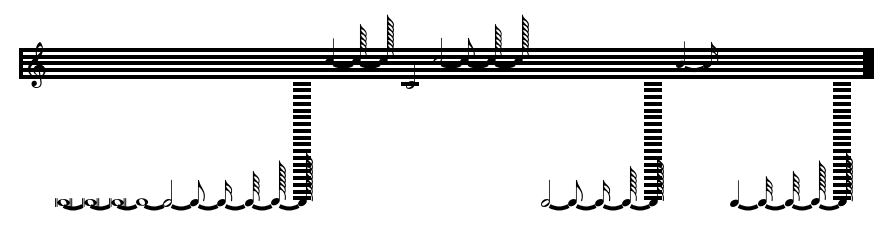

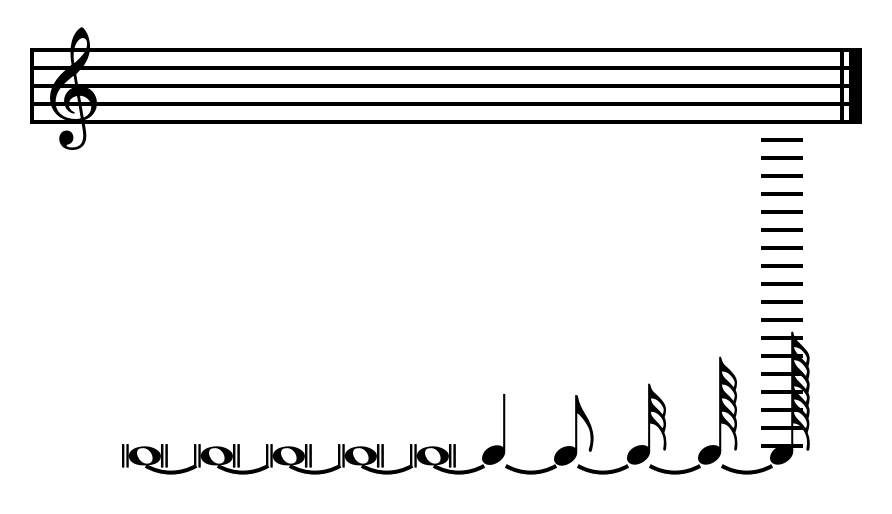

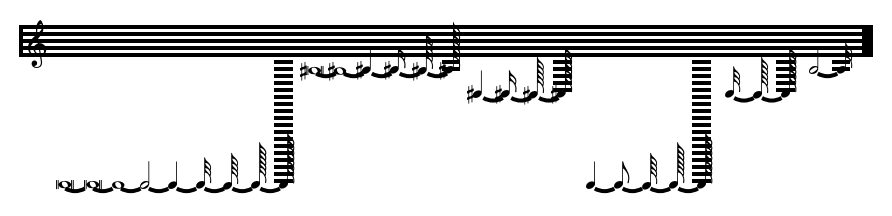

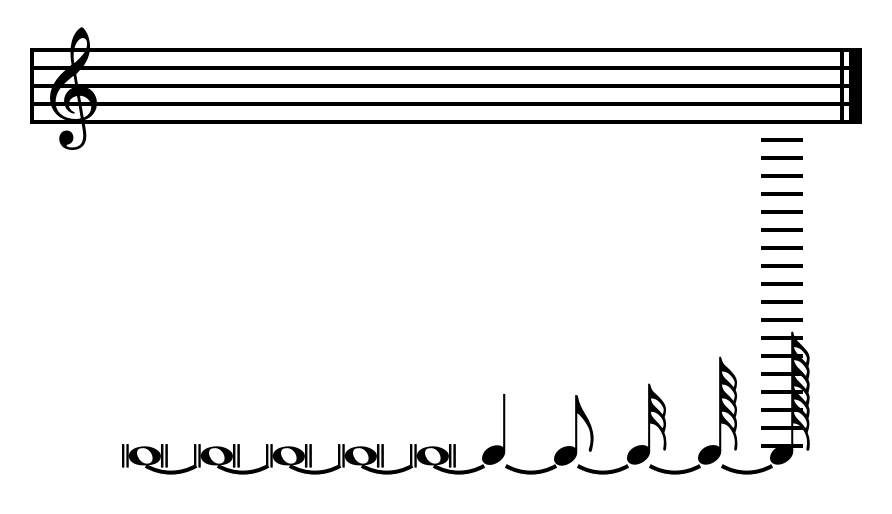

In [18]:
import numpy as np

muspy.download_bravura_font()
muspy.download_musescore_soundfont()

# model.eval()

for i, batch in enumerate(val_dataloader):
    if (i<10): continue
    if i == 12: break
    X = batch[0].permute(1,0).to(device)
    
    seq = X[0]
    recon = model.forward(seq)
    
    recon = recon.detach().numpy()


    test = muspy.from_pitch_representation(np.asarray(seq, dtype=int))
    test2 = muspy.from_pitch_representation(np.asarray(recon, dtype=int))

    muspy.show_score(test)
    muspy.show_score(test2)
    
    muspy.write_audio("./test.wav", test)
    muspy.write_audio("./test2.wav", test2)